In [1]:
!pip install tf_keras_vis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 1.8 MB/s eta 0:00:00


# Chapter 3 Deeplearning (2) CNN - Visualization
- tensorflow keras vis 라이브러리를 활용한 GradCAM, 필터시각화

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models, datasets, Model
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ExtractIntermediateLayer, ReplaceToLinear
from tf_keras_vis.activation_maximization import ActivationMaximization
from matplotlib import pyplot as plt
import numpy as np

In [4]:
# VGG 스타일 모델 생성 (Functional API 사용)
def build_vgg_style_model():
    inputs = tf.keras.Input(shape=(28, 28, 1))  # MNIST는 흑백 이미지이므로 채널이 1입니다.

    # Conv 레이어
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='conv2d_1')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu', name='conv2d_2')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu', name='conv2d_3')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Dense 레이어
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    outputs = layers.Dense(10, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [5]:
# MNIST 데이터셋 불러오기
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

# 데이터 전처리: 차원 확장과 정규화
x_train = np.expand_dims(x_train, -1) / 255.0  # (28, 28, 1) 크기로 변환 및 0-1 정규화
x_test = np.expand_dims(x_test, -1) / 255.0

# 모델 생성
model = build_vgg_style_model()

# 모델 학습 (간단하게 1 epoch만 사용)
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))



11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9193 - loss: 0.2455 - val_accuracy: 0.9895 - val_loss: 0.0334
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9883 - loss: 0.0384 - val_accuracy: 0.9837 - val_loss: 0.0515
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9908 - loss: 0.0287 - val_accuracy: 0.9908 - val_loss: 0.0283
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9933 - loss: 0.0208 - val_accuracy: 0.9904 - val_loss: 0.0294
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9954 - loss: 0.0142 - val_accuracy: 0.9919 - val_loss: 0.0290
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9962 - loss: 0.0113 - val_accuracy: 0.9880 - val_loss: 0.0441
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9964 - loss: 0.0116 - val_accuracy: 0.9888 - val_loss: 0.0485
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━

## 활성화 맵 시각화 - GradCAM
특정 클래스에 대한 예측을 할 때, 입력 이미지의 어느 부분이 중요한지 보여주는 활성화 맵을 시각화

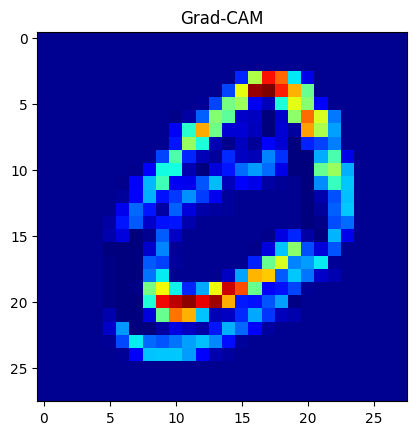

In [6]:
# Grad-CAM 설정
gradcam = Gradcam(model, model_modifier=ReplaceToLinear(), clone=False)

# Grad-CAM을 위한 스코어 설정 (class)
score = CategoricalScore([2])

# MNIST 샘플 이미지 선택
sample_image = x_train[1:2]  # 첫 번째 이미지를 샘플로 선택

# Grad-CAM 생성
cam = gradcam(score, sample_image, penultimate_layer='conv2d_1')
heatmap = np.uint8(255 * cam[0])

# Grad-CAM 결과 시각화
plt.imshow(heatmap, cmap='jet')
plt.title('Grad-CAM')
plt.show()


## 필터시각화
필터 웨이트 시각화는 CNN의 각 필터(커널) 자체를 시각화  
random input을 넣었다 (seed input)

In [7]:
layer_name = 'conv2d_1' # The target layer that is the last layer of VGG16.
filter_numbers = [0,2,4]
scores = CategoricalScore(filter_numbers)
# This instance constructs new model whose output is replaced to `block5_conv3` layer's output.
extract_intermediate_layer = ExtractIntermediateLayer(index_or_name=layer_name)
replace2linear = ReplaceToLinear() # ReplaceToLinear()를 사용하여 모델의 마지막 레이어를 선형 레이어로 변환하여 시각화에 적합하게 만듬

In [8]:
seed_input = tf.random.uniform((3, 28, 28, 1), 0, 255)

200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - Score: 0.4744 - TotalVariation2D: 8.9817 - Norm: 18.5520


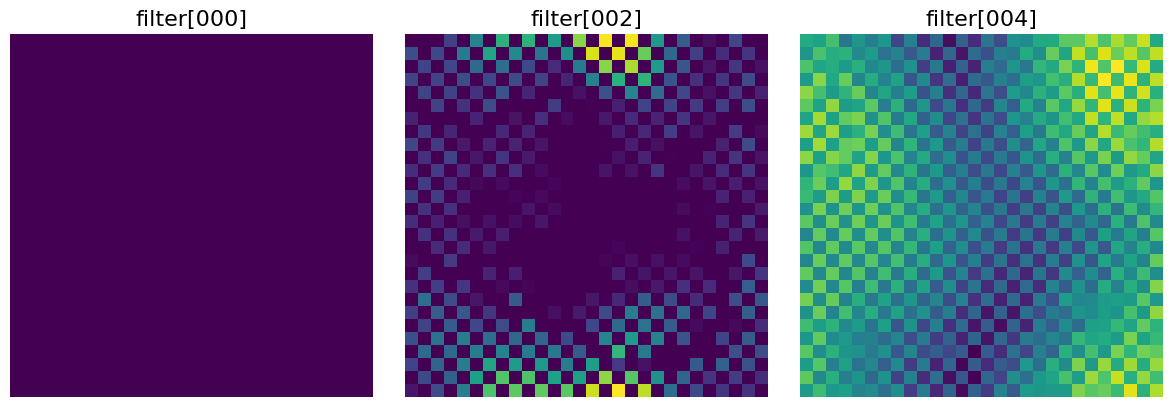

In [9]:
# 필터 시각화를 위한 Activation Maximization
activation_maximization = ActivationMaximization(model,
                                                 # Please note that `extract_intermediate_layer` has to come before `replace2linear`.
                                                 model_modifier=[extract_intermediate_layer, replace2linear],
                                                 clone=False)

from tf_keras_vis.activation_maximization.callbacks import Progress

# Generate maximized activation
activations = activation_maximization(scores,
                                      seed_input=seed_input,
                                      callbacks=[Progress()])

# activations = activations[0].astype(np.uint8)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, filter_number in enumerate(filter_numbers):
    ax[i].set_title('filter[{:03d}]'.format(filter_number), fontsize=16)
    ax[i].imshow(activations[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()